In [1]:
import numpy as np
from dendropy import Tree
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from utils import setup_plotting_standards, basic_formatting
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pandas as pd

setup_plotting_standards()
COLOR = '#343434'

# Supplemental Figure 3: Root-to-tip divergence
Here, we assess whether any of the newly generated sequences are more divergent than expected given their sampling data.

First, we load in the tree, and calculate the distance of each taxa to the root of the tree, this is called root-to-tip divergence. We then load the metadata to get collection dates and origins of each sequence.

In [13]:
tree = Tree.get( path="../data/2024.08.06_ML_GTR.tree", schema="newick", preserve_underscores=True )

divergence = {
    "taxa" : [],
    "divergence" : []
}

for taxa in tree.leaf_node_iter():
    divergence["taxa"].append( taxa.taxon.label )
    divergence["divergence"].append( taxa.distance_from_root() )
    
divergence = pd.DataFrame( divergence )

md = list()
for file in ["supplemental_data1.csv", "supplemental_data2.csv"]:
    df = pd.read_csv( "../data/" + file, usecols=["taxa", "collection_date"], parse_dates=["collection_date"] )
    df["workshop"] = (file == "supplemental_data1.csv")
    md.append( df )
    
md = pd.concat( md )
md = md.merge( divergence, on="taxa", how="left" )
md.head()


,taxa,collection_date,workshop,divergence
0,Africa|CMR|CMR_CEN005NA35|T12|2023-04-12,2023-04-12,True,0.017591
1,Africa|CMR|CMR_CEN032BM-B48|T12|2023-05-04,2023-05-04,True,0.017595
2,Africa|CMR|CMR_E05557442|T12|2023-05-12,2023-05-12,True,0.017949
3,Africa|CMR|CMR_CEN030DA43|T12|2023-05-03,2023-05-03,True,0.017592
4,Africa|CMR|CMR_CEN027NV44|T12|2023-05-01,2023-05-01,True,0.017594


We convert collection dates to units of decimal years, and then perform a linear regression of collection dates vs. divergence to estimate the substitution rate. We then label all taxa that have a residual greater than 4 interquartile distances from the regression model as outliers. This is almost a straight copy from TreeTime's clock filter algorithm, so H/t to them.

In [14]:
data = md.loc[md["divergence"].notna()&md["collection_date"].notna()].copy()
data["decimal_year"] = data["collection_date"].dt.year + (data["collection_date"].dt.dayofyear / 365.25)

model = LinearRegression()
model.fit(data[["decimal_year"]], data["divergence"])
r2_score = model.score(data[["decimal_year"]], data["divergence"])
slope = model.coef_
intercept = model.intercept_

data["residual"] = data["divergence"] - (slope*data["decimal_year"] + intercept)

interquartile = np.percentile( data["residual"], 75 ) - np.percentile( data["residual"], 25 )

data["outlier"] = data['residual'].abs() > (interquartile * 4)

Finally, we generate a scatter plot of collection dates vs. divergence, labeling sequences by whether they were collected by CholGEN or not, and whether they were an outlier or not. This generates Supplemental Figure 4.

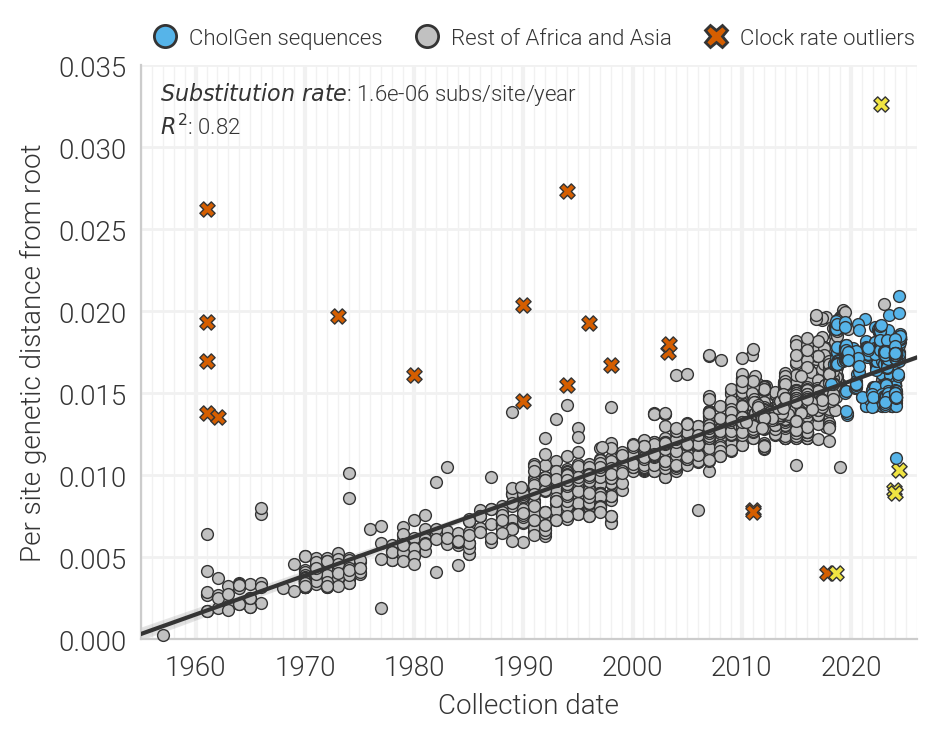

In [16]:
fig, ax = plt.subplots( dpi=200, figsize=(5,4) )

# Background
spots = ax.scatter( "decimal_year", "divergence", data=data.loc[~data["outlier"]&~data["workshop"]], color="#C1C1C1", edgecolor=COLOR, linewidth=0.5, s=18, zorder=3 )
spots.set_clip_on( False )

##background outliers
#ax.scatter( "decimal_year", "divergence", data=data.loc[data["outlier"]&~data["workshop"]], marker="X", color=COLOR, s=30, zorder=8 )
ax.scatter( "decimal_year", "divergence", data=data.loc[data["outlier"]&~data["workshop"]], marker="X", color="#C1C1C1", s=30, edgecolor=COLOR, linewidth=0.5, zorder=9 )

sns.regplot( x=data["decimal_year"], y=data["divergence"], color=COLOR, scatter=False, line_kws={"zorder" : 20, "linewidth" : 1.5}, ax=ax, truncate=False )

## CholGen
#ax.scatter( "decimal_year", "divergence", data=data.loc[data["workshop"]&~data["outlier"]], color=COLOR, s=18, zorder=10)
ax.scatter( "decimal_year", "divergence", data=data.loc[data["workshop"]&~data["outlier"]], color="#56B4E9", edgecolor=COLOR, linewidth=0.5, s=18, zorder=11 )

##CholGen outliers
ax.scatter( "decimal_year", "divergence", data=data.loc[data["workshop"]&data["outlier"]], marker="X", color="#56B4E9", s=30, edgecolor=COLOR, linewidth=0.5, zorder=9 )


legend = [
    Line2D([0], [0], linestyle='none', marker='o', color="#56B4E9", markeredgewidth=1, markeredgecolor=COLOR, label="CholGen sequences", markersize=8 ),
    Line2D([0], [0], linestyle='none', marker='o', color="#C1C1C1", markeredgewidth=1, markeredgecolor=COLOR, label="Rest of Africa and Asia", markersize=8 ),
    Line2D([0], [0], linestyle='none', marker='X', color="#C1C1C1", markeredgewidth=1, markeredgecolor=COLOR, label="Clock rate outliers", markersize=8 ),
    #Line2D([0], [0], linestyle='none', marker='X', color="#E69F00", markeredgewidth=1, markeredgecolor=COLOR, label="CholGen outliers", markersize=8 )
]
ax.legend( handles=legend, loc="upper center", bbox_to_anchor=(0,0,1,1.1), handletextpad=0.075, frameon=False, fontsize=8, ncols=4, columnspacing=1, edgecolor="None" )

ax.set_xticks( range( 1950, 2030, 1 ), minor=True )
basic_formatting( ax, which="both", xlabel="Collection date", ylabel="Per site genetic distance from root", xlims=(1955,2026), ylims=(0,0.035), xsize=10, ysize=10 )

#ax.grid( False )
ax.grid( which="major", axis="x", linewidth=1.5, color="#F1F1F1", zorder=1 )
ax.grid( which="minor", axis="x", linewidth=0.5, color="#F1F1F1", zorder=1 )

ax.annotate( f"$Substitution\ rate$: {slope[0] * 27714 / 4033501:.1e} subs/site/year" , xy=(0.025, 0.94), xycoords="axes fraction", fontsize=8)
ax.annotate( f"$R^2$: {r2_score:.2f}" , xy=(0.025, 0.88), xycoords="axes fraction", fontsize=8)

plt.tight_layout()
plt.savefig( "plots/figureS2-root-to-tip.pdf" )
plt.savefig( "plots/figureS2-root-to-tip.png" )
plt.show()